In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [38]:
# 3
train_image_generator = ImageDataGenerator(rescale = 1/255.0)
validation_image_generator = ImageDataGenerator(rescale=1/255.0)
test_image_generator = ImageDataGenerator(rescale=1/255.0)

train_data_gen = train_image_generator.flow_from_directory(
    directory = train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory = validation_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary'
)
test_data_gen = test_image_generator.flow_from_directory(
    directory = PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    shuffle = False,
    classes = ['test']
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


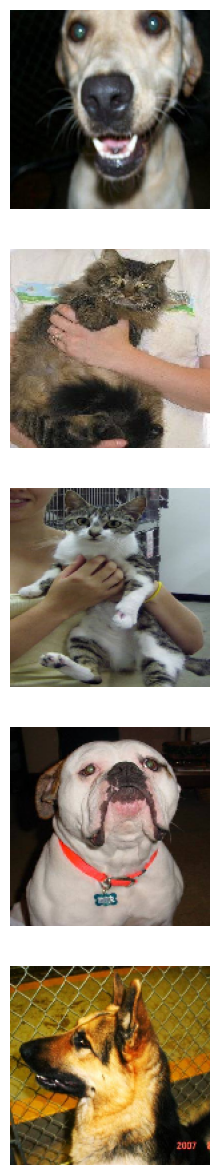

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [39]:
# 5
train_image_generator = train_image_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True
)


Found 2000 images belonging to 2 classes.


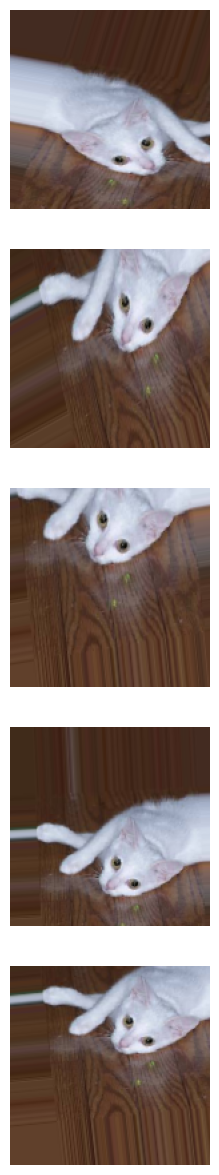

In [40]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary' )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [43]:
# 7
#from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

input_layer = Input(train_data_gen.image_shape)
x = Conv2D(9, kernel_size = 3, strides = 2)(input_layer)
x = MaxPooling2D((5,5))(x)

x = Conv2D(15, kernel_size = 3, strides = 2)(x)
x = MaxPooling2D()(x)

x = Conv2D(25, kernel_size = 2, strides = 1)(x)
x = MaxPooling2D((1,1))(x)

x = Flatten()(x)

x = Dense(512, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(256, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(8, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(1, 'sigmoid')(x)

model = Model(input_layer, x)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 74, 74, 9)         252       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 14, 14, 9)         0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 6, 6, 15)          1230      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 3, 15)          0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 2, 2, 25)          152

In [44]:
# 8
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_accuracy.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_data_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_data_gen,
    callbacks = [save_best]
)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.5635
Epoch 1: val_accuracy improved from -inf to 0.57800, saving model to best_accuracy.keras
16/16 [==============================] - 19s 861ms/step - loss: 0.7054 - accuracy: 0.5635 - val_loss: 0.6861 - val_accuracy: 0.5780
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.5960
Epoch 2: val_accuracy improved from 0.57800 to 0.60600, saving model to best_accuracy.keras
16/16 [==============================] - 16s 1s/step - loss: 0.6601 - accuracy: 0.5960 - val_loss: 0.6799 - val_accuracy: 0.6060
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.6215
Epoch 3: val_accuracy did not improve from 0.60600
16/16 [==============================] - 15s 944ms/step - loss: 0.6424 - accuracy: 0.6215 - val_loss: 0.6764 - val_accuracy: 0.5870
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.6350

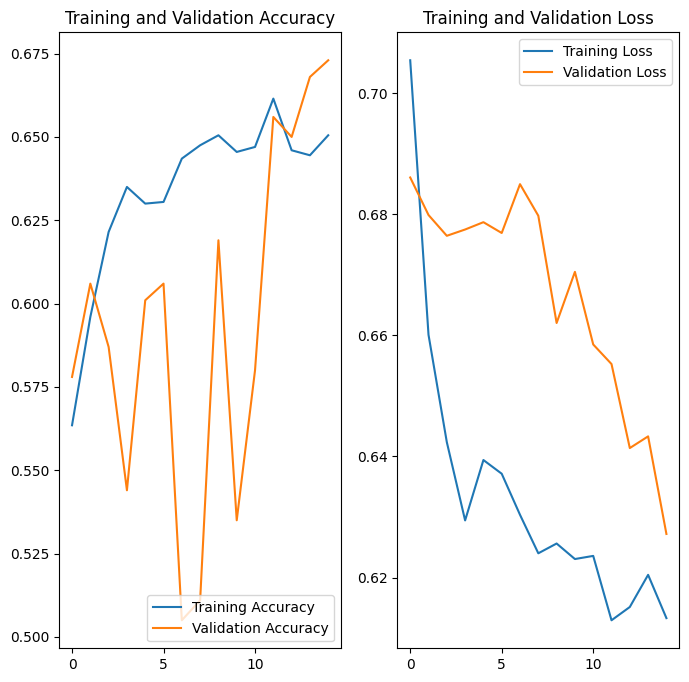

In [45]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

1/1 [==============================] - 0s 217ms/step


array([0.36733913, 0.329063  , 0.40419585, 0.6369454 , 0.46583223,
       0.46548253, 0.41771376, 0.31513304, 0.5774102 , 0.6939529 ,
       0.56222826, 0.49666744, 0.45083502, 0.34226236, 0.43942457,
       0.5935168 , 0.46184984, 0.62574506, 0.5572182 , 0.5250495 ,
       0.40063998, 0.54867744, 0.4425028 , 0.5785718 , 0.49208978,
       0.507569  , 0.4922616 , 0.3383258 , 0.40155193, 0.44630674,
       0.40387756, 0.4103548 , 0.56661516, 0.8217963 , 0.37876827,
       0.5646207 , 0.8206913 , 0.54333895, 0.38397428, 0.35897353,
       0.42213324, 0.4691801 , 0.45058328, 0.40164968, 0.42485967,
       0.45429593, 0.42778468, 0.5169937 , 0.42796886, 0.46883354],
      dtype=float32)

In [47]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
